## $\chi^{2}$ distribution

Let $Z_{1}, Z_{2}, ..., Z_{k}$ be independent, standard normal random variables.

The sum of the squares of these $Z_{i}$ variables: 

\begin{equation}
Q = \sum\limits_{i=1}^{k} Z^{2}_{i}
\end{equation}

is distributed according to a $\chi^{2}$ distribution with number of degress of freedom equal to the number of variables summed, i.e. $n_{d.o.f.} = k$:

\begin{equation}
Q \sim \chi^{2}(k)
\end{equation}

## Pearson $\chi^{2}$ test

The sum of relative deviations given:
- our observations of data $\mathbf{n_{data}}$ (Gaussian distributed in each bin)
- the predicted values $\mathbf{n_{pred}}(\theta)$ ($\theta$ being the parameters of our model)
- and their uncertainty $\mathbf{\sigma}$

is:

\begin{equation}
S = \sum\limits_{i=1}^{n} \frac{ ( n_{i,data} - n_{i,pred} (\theta) )^{2} }{ \sigma^{2}_{i,data}}
\end{equation}

Let's denote $S_{min}$ as the minimum of $S$ achivable by varying $\mathbf{\theta}$.

**Statement:**

$S_{min}$ is distributed as $\chi^{2}$ with $n_{d.o.f} = n_{data} - n_{\theta}$.

**Objective of this notebook:**

is to show validity of the above statement through an example.

## References:

- https://en.wikipedia.org/wiki/Chi-squared_distribution
- https://www.pp.rhul.ac.uk/~cowan/stat/stat_3.pdf
- https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

Importing the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import ncx2
from scipy.optimize import minimize
%matplotlib inline

## Showing that $Q = \sum\limits_{i=1}^{k} Z^{2}_{i} \sim \chi^{2}(k)$ 

Degrees of freedom:

In [99]:
k = 20

Function to get $Q$ for $n_{points}$

In [107]:
def get_Q(npoints):
    x = norm.rvs(size=npoints)
    Q = np.sum(x**2)
    return Q

Generate an ensemble of $Q$s:

In [103]:
Q_ensemble = [get_Q(k) for i in range(10000)]

$\chi^{2}$ pdf with $k=20$:

In [112]:
chi2_x = np.linspace(0.0, 100.0, 100)
chi2_y20dof = chi2.pdf(chi2_x, 20)

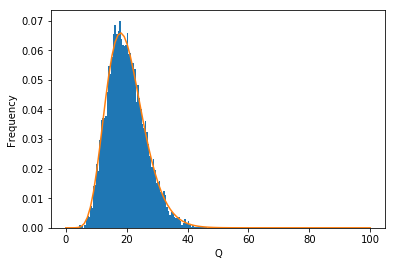

In [114]:
f, a = plt.subplots()
n, bins, patches = a.hist(Q_ensemble, bins=100, range=(0.0,50.0), normed=True)
a.plot(chi2_x, chi2_y20dof)
a.set_xlabel("Q");
a.set_ylabel("Frequency");

## Demonstrating minimization procedure <br/> (with `scipy.optimize.minimize`)

To demonstrate that the minimzation procedure indeed works we'll take a simple quadratic function and try to find its minimum.

Defining the parabola

In [2]:
def parabola(x):
    y = (x-2.0)**2.0 + 1
    return y

In [3]:
x = np.linspace(-5.0, 5.0, 100)
y = parabola(x)

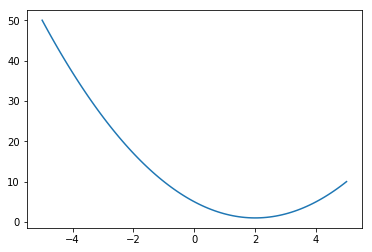

In [4]:
plt.plot(x,y);

Perform minimzation with default settings

In [5]:
m = minimize(parabola, [3])

Results of the minimization

In [6]:
def display_minimization_result(m):
    print("m['success']: ", m['success'])
    print("m['fun']:     ", m['fun'])
    print("m['x']:       ", m['x'])

In [7]:
display_minimization_result(m)

m['success']:  True
m['fun']:      1.0
m['x']:        [ 1.99999999]


Should get a value of `m['x']` which is close to the location of the minimum of the function above:
\begin{equation}
\texttt{m['x']} \approx 2.0
 \end{equation}

## Minimization of the sum of relative squared deviations

In the following we consider an example of polynomial fiting with with order 2 (aka straight line). Here we create an ensemble of datasets where each dataset is generated by our model + random noise. After creating this ensemble we evaluate the $S_{min}$ for each dataset and examine its distribution.

### Domain

In [8]:
ndatapoints = 20
x = np.linspace(0.0, 5.0, ndatapoints)
data = {}
data['x'] = x

### True signal (straigth line)

Parameters

In [9]:
a = 2.4
b = 1.1

In [10]:
signal = a*x + b

### Noise (Gaussian)

Parameters

In [11]:
mean = 0.0
std  = 0.3

In [13]:
noise = np.random.normal(mean, std, ndatapoints)

## Data = True signal + Noise

Dictionary holding the data and its uncertainty

In [14]:
data = {}
data['y']   = signal + noise
data['err'] = std

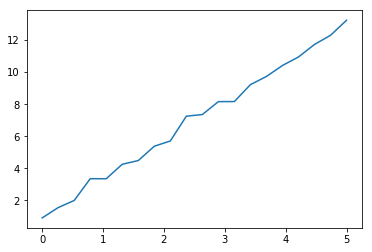

In [15]:
plt.plot(x, data['y']);

## Generate data

In [30]:
def generate_data(a, b, noise_mean, noise_std):
    x  = np.linspace(0.0, 5.0, ndatapoints)
    signal = a*x + b
    noise = np.random.normal(noise_mean, noise_std, ndatapoints)
    data['x'] = x
    data['y'] = signal + noise
    data['err'] = noise_std
    return data

## Our model

In [31]:
def data_model(x, a, b):
    y = a*x + b
    return y

**Test**

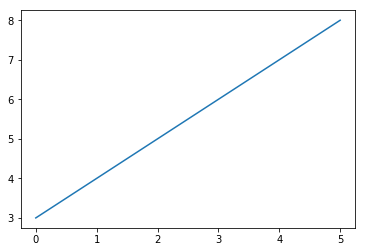

In [32]:
y_model = data_model(x, a=1.0, b=3.0);
plt.plot(x, y_model);

## Constructing the sum of relative squared deviations

In [33]:
def sum_of_rel_deviation(y_obs, y_predicted, error):
    """Simple function to calculate the sum of the relative squared deviations,
    given the observed- and predicted values, and the associated uncertainty for
    the observed values."""
    rel_deviation = (y_obs-y_predicted)**2/error**2
    S = np.sum(rel_deviation)
    return S

**Test example**

In [34]:
sum_of_rel_deviation(data['y'], y_model, error=1.0) 

135.90801685822015

In [35]:
def calc_sum_of_rel_deviation_for_model(model_params, model, data ):
    """Get the sum of relative deviations for a particular realization
       of data given the model parameters, the model and the observed data."""
    y_predicted = model(data['x'], *model_params)
    S = sum_of_rel_deviation(data['y'], y_predicted, data['err'])
    return S

In [36]:
data = generate_data(a=1.5, b=3.5, noise_mean=0.0, noise_std=0.3)

Initial guesses for the parameters:

In [37]:
initial_guess_a = 5.0
initial_guess_b = 3.0

In [38]:
m = minimize(calc_sum_of_rel_deviation_for_model, [initial_guess_a, initial_guess_b], method = 'Nelder-Mead', args=(data_model,data))

In [39]:
display_minimization_result(m)

m['success']:  True
m['fun']:      37.3261070605
m['x']:        [ 1.46999492  3.58014534]


In [40]:
a = 1.0
b = 3.0
noise_mean = 0.0
noise_std  = 0.3

In [41]:
initial_guess_a = 5.0
initial_guess_b = 3.0

To be able to get an ensemble of $S_{min}$ we create a function which generates a dataset consisting of a sample with different realization of a Gaussian distributed noise for each call, and returns the minimum just like above:

In [42]:
def get_min_sum_of_rel_deviation():
    """Get the minimum of the sum of relative deviations."""
    data = generate_data(a, b, noise_mean, noise_std)
    m = minimize(calc_sum_of_rel_deviation_for_model, [initial_guess_a, initial_guess_b], method = 'Nelder-Mead', args=(data_model,data))
    return m['fun']

In [43]:
get_min_sum_of_rel_deviation()

10.182960097701477

Generate an ensemble of $S_{min}$:

In [44]:
S_min_ensemble = [get_min_sum_of_rel_deviation() for i in range(10000)]

In [79]:
S_x = np.linspace(0.0, 100.0, 100)
S_y16dof = chi2.pdf(S_x, 16)
S_y17dof = chi2.pdf(S_x, 17)
S_y18dof = chi2.pdf(S_x, 18)
S_y19dof = chi2.pdf(S_x, 19)
S_y20dof = chi2.pdf(S_x, 20)

Notice that it is $\chi^{2}(n_{d.o.f.} = 18)$ which follows the distribution of $S_{min}$ the closest.

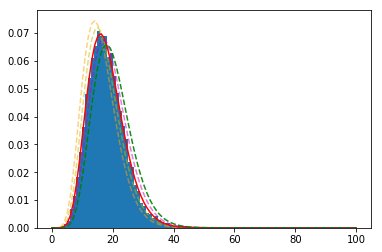

In [82]:
f,a = plt.subplots()
n, bins, patches = plt.hist(S_min_ensemble, bins=100, range=(0.0, 100.0), normed=True, histtype="stepfilled");
plt.plot(S_x, S_y16dof, c='orange', linestyle='--', alpha=0.5);
plt.plot(S_x, S_y17dof, c='y', linestyle='--', alpha=0.5);
plt.plot(S_x, S_y18dof, c='r');
plt.plot(S_x, S_y19dof, c='m', linestyle='--', alpha=0.5);
plt.plot(S_x, S_y20dof, c='g', linestyle='--', alpha=0.9);

In [73]:
def S(y1, y2, unc_sq):
    square = (y1-y2)**2
    array = np.where(unc_sq==0, 0, square/unc_sq)
    return np.sum(array)

In [83]:
S(n, S_y17dof, S_y17dof)

/home/edy/lib/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.024654935599243661

In [75]:
S(n, S_y18dof, S_y18dof)

/home/edy/lib/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.011130212856629426

In [84]:
S(n, S_y19dof, S_y19dof)

/home/edy/lib/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.065697877999065499

In [85]:
S(n, S_y20dof, S_y20dof)

/home/edy/lib/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.2014020245891934